<b>An Algorithm for Neural Style Transfer</b>

Paper Link:
https://arxiv.org/abs/1508.06576


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import PIL.Image
import time
import functools
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import time
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
tf.config.experimental_run_functions_eagerly(True)

TensorFlow 2.x selected.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
#                                        'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg',
#                                      'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


In [2]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                       'https://github.com/pytorch/examples/raw/master/fast_neural_style/images/content-images/amber.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg',
                                     'https://github.com/pytorch/examples/raw/master/fast_neural_style/images/style-images/mosaic.jpg')

81920/77378 [===============================] - 0s 0us/step


In [0]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


In [0]:

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [0]:
#HelperFunctions
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

  return model
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [0]:
class StyleTransfer:
  def __init__(self,content_img_path,style_img_path):
    self.content_image=load_img(content_img_path)
    self.style_image=load_img(style_img_path)
    self.style_weight=1e-2
    self.content_weight=1e4
    self.addVariationalLoss=False
    self.VariationWeight=30
  def create_extractor(self,content_layers,style_layers):
    self.extractor=StyleContentModel(style_layers, content_layers)
    self.num_style_layers=len(style_layers)
    self.num_content_layers=len(content_layers)

  def clip_0_1(self,image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
  @tf.function()
  def train_step(self,image):
    with tf.GradientTape() as tape:
      outputs = self.extractor(image)
      loss = self.style_content_loss(outputs)
      if self.addVariationalLoss:
        loss += self.VariationWeight*tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt=tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
    opt.apply_gradients([(grad, image)])
    image.assign(self.clip_0_1(image))
  def style_content_loss(self,outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-self.style_targets[name])**2) 
                            for name in style_outputs.keys()])
    style_loss *= self.style_weight / self.num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-self.content_targets[name])**2) 
                              for name in content_outputs.keys()])
    content_loss *= self.content_weight / self.num_content_layers
    loss = style_loss + content_loss
    #loss=style_loss
    return loss
  def __call__(self,epochs=10,steps_per_epoch=100,canvas=1,style=1e-2,content=1e5):
    self.style_weight=style
    self.content_weight=content
    self.style_targets = self.extractor(self.style_image)['style']
    self.content_targets = self.extractor(self.content_image)['content']

    if(isinstance(canvas,int)):
      image=tf.Variable(self.content_image)
    else:
      image=tf.Variable(canvas)


    start = time.time()

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        self.train_step(image)
        print(".", end='')
      display.clear_output(wait=True)
      display.display(tensor_to_image(image))
      print("Train step: {}".format(step))
      
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
    return image

In [0]:
obj=StyleTransfer(content_img_path=content_path,style_img_path=style_path)
obj.create_extractor(content_layers,style_layers)

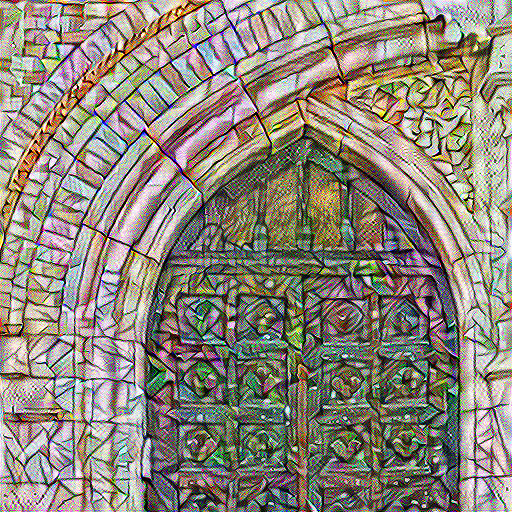

Train step: 1000
Total time: 99.4


<tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32, numpy=
array([[[[0.48175165, 0.25383404, 0.3078627 ],
         [0.6962352 , 0.45919383, 0.37712884],
         [0.55633307, 0.12396859, 0.02018433],
         ...,
         [0.6410066 , 0.76103425, 0.52049655],
         [0.5154745 , 0.5253091 , 0.6515048 ],
         [0.10805953, 0.91757315, 0.01537712]],

        [[0.47284004, 0.9405273 , 0.8058133 ],
         [0.3894266 , 0.21443729, 0.13675039],
         [0.89403343, 0.8719472 , 0.6143427 ],
         ...,
         [0.77547395, 0.53729653, 0.2674277 ],
         [0.7299123 , 0.01998571, 0.6775529 ],
         [0.45987058, 0.9414385 , 0.73853433]],

        [[0.63122493, 0.79376453, 0.40447733],
         [0.97943157, 0.8459521 , 0.95962286],
         [0.3203838 , 0.32703513, 0.69265467],
         ...,
         [0.7474946 , 0.71694595, 0.25654766],
         [0.8008903 , 0.2923885 , 0.56584823],
         [0.0941839 , 0.82755595, 0.21078739]],

        ...,

        [[0.35508254,

In [11]:
obj()

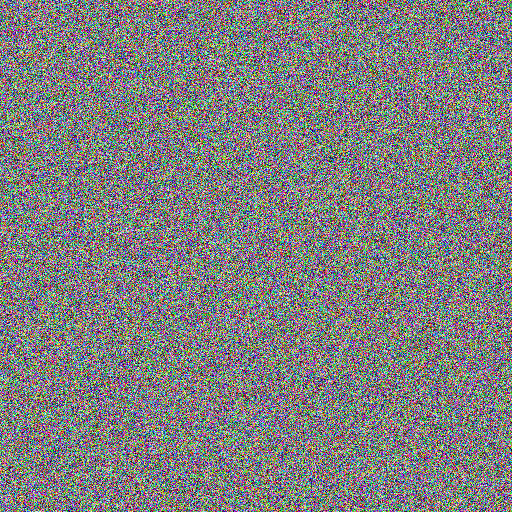

In [17]:
image=tf.random.uniform(obj.content_image.shape,maxval=1)
image=tf.Variable(image)
tensor_to_image(image)

In [21]:
obj(canvas=image,style=1e-2,content=1e5,epochs=40)

KeyboardInterrupt: ignored

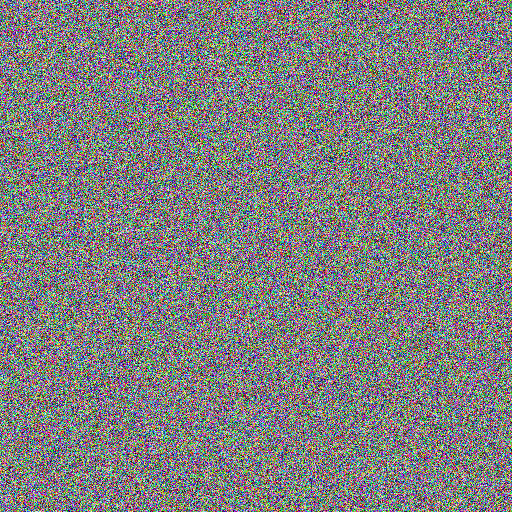

In [20]:
tensor_to_image(image)

In [0]:
tf.keras.utils.get_file('puppy-1903313_960_720.jpg', 
                                       'https://image.shutterstock.com/image-photo/mountains-during-sunset-beautiful-natural-260nw-407021107.jpg')
image=load_img('/root/.keras/datasets/puppy-1903313_960_720.jpg')
image=tf.image.resize(image,(422,512))
tensor_to_image(canvas=image)

57344/50313 [==================================] - 0s 0us/step


'/root/.keras/datasets/puppy-1903313_960_720.jpg'

In [0]:
obj(canvas=image)

Demonstartion of High Variation.

In [0]:
x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")
plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")
x_deltas, y_deltas = high_pass_x_y(image)
plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")
plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [0]:
plt.figure(figsize=(14,10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1,2,1)
imshow(clip_0_1(sobel[...,0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1,2,2)
imshow(clip_0_1(sobel[...,1]/4+0.5), "Vertical Sobel-edges")

In [0]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [0]:
total_variation_loss(image).numpy()

Adding Variation Loss in the Object


In [24]:
obj.addVariationalLoss

False

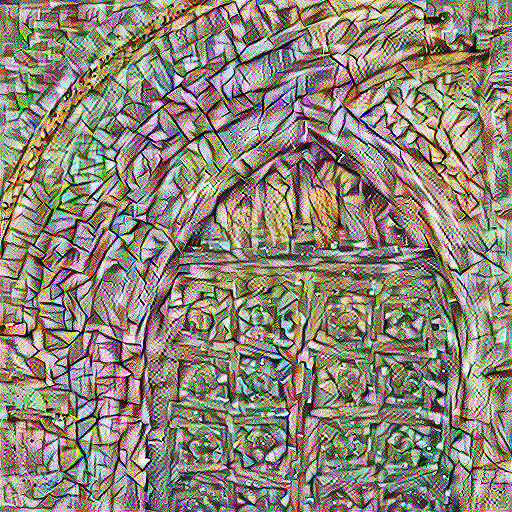

Train step: 2000
Total time: 206.7


<tf.Variable 'Variable:0' shape=(1, 512, 512, 3) dtype=float32, numpy=
array([[[[0.11357827, 0.13663417, 0.11897844],
         [0.33920282, 0.26280862, 0.54302025],
         [0.44764116, 0.09794688, 0.1336368 ],
         ...,
         [0.48069987, 0.5200288 , 0.36057812],
         [0.30842245, 0.48157892, 0.34877667],
         [0.19526234, 0.6676184 , 0.45119718]],

        [[0.13923325, 0.07644942, 0.87861365],
         [0.5615119 , 0.23089124, 0.38889   ],
         [0.59853137, 0.02000172, 0.09787135],
         ...,
         [0.5968472 , 0.42771208, 0.34894097],
         [0.5384228 , 0.680188  , 0.2562612 ],
         [0.3521303 , 0.5163212 , 0.46809465]],

        [[0.01999427, 0.10892345, 0.69448555],
         [0.03988238, 0.03997609, 0.9193905 ],
         [0.28927636, 0.5325665 , 0.19401579],
         ...,
         [0.62376165, 0.4378329 , 0.4212178 ],
         [0.6345803 , 0.19009157, 0.41075772],
         [0.40264735, 0.4041177 , 0.41629574]],

        ...,

        [[0.76106685,

In [25]:
obj.addVariationalLoss=True
obj(canvas=image,style=1e-2,content=1e5,epochs=20)